# Data Mining Process

The goal of this notebook is to implement a data mining process chain according to [CRISP](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining).    
For educational purposes the [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) dataset is analyzed. 

In [8]:
import numpy as np 
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

path_dataset = '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


## Data Access

In the following section I take a look at at the dataset to get a first impression.    
I check the available data, the data types and scan for any pitfalls, e.g. parsing errors, NaNs or unexpected parsing results.

In [9]:
# Load the file churnPrediction.csv-file into a pandas dataframe
df = pd.read_csv(path_dataset)
# get first impression on predictive churn data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
print(f'Dataset shape: {df_churn_predict.shape}')

Dataset shape: (7043, 21)


In [12]:
# Check out a detailed description of the data.
# Mostly interested in the data types and any non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Observation:**    
In total there are 21 data columns, including int64, float64 and object data types.
At first glance the dataset seems to be complete, with 7043 entries in each column.
Judging from the column names almost all data that should be numerical is either of float or integer data type.
An exception is found in the "TotalCharges" column, which is indicated as object data type.
Missing values may be a possible cause for this mismatch.
To verify this assumption the dataset is checked once again, replacing empty strings explicitly with NaN-values.

In [14]:
df = pd.read_csv(path_dataset, na_values=[' ', ''])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Replacing empty strings with NaNs shows the expected data type of float64 for "TotalCharges".
The dataset info now also reveals that 11 values are indeed empty.    
Since this is only a very small fraction of the dataset the corrupted rows will just be dismissed.

In [15]:
df.dropna(inplace=True)
print(f'New dataset shape: {df.shape}')

New dataset shape: (7032, 21)


# Preprocess and Understand Data

After ensuring that the dataset can be accessed properly and the data is indeed clean the data may be analyzed more closely.

## Check Feature Domains

In [18]:
# Check value ranges of data
for col in df:
    print(f'Feature: {col}')
    print(f'Values: {df[col].unique()[:5]}')
    print('---')

Feature: customerID
Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU']
---
Feature: gender
Values: ['Female' 'Male']
---
Feature: SeniorCitizen
Values: [0 1]
---
Feature: Partner
Values: ['Yes' 'No']
---
Feature: Dependents
Values: ['No' 'Yes']
---
Feature: tenure
Values: [ 1 34  2 45  8]
---
Feature: PhoneService
Values: ['No' 'Yes']
---
Feature: MultipleLines
Values: ['No phone service' 'No' 'Yes']
---
Feature: InternetService
Values: ['DSL' 'Fiber optic' 'No']
---
Feature: OnlineSecurity
Values: ['No' 'Yes' 'No internet service']
---
Feature: OnlineBackup
Values: ['Yes' 'No' 'No internet service']
---
Feature: DeviceProtection
Values: ['No' 'Yes' 'No internet service']
---
Feature: TechSupport
Values: ['No' 'Yes' 'No internet service']
---
Feature: StreamingTV
Values: ['No' 'Yes' 'No internet service']
---
Feature: StreamingMovies
Values: ['No' 'Yes' 'No internet service']
---
Feature: Contract
Values: ['Month-to-month' 'One year' 'Two year']
---
Feature: Pap

In [20]:
# Get a better overview of the numerical data
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


By inspecting the data closer it becomes clear that data types are still not consistent.
For example, "SeniorCitizen" is of integer type but actually describes categorical data.
Other categorical data is described as strings.

## Transformation of non-numerical data

To make the dataset consistent and to allow further processing with ML algorithms the categorical data is converted into a numeric representation.
For this purpose the LabelEncoder of scikit-learn is used.    
The CustomerId does not contain valuable data for analysis, therefore this feature will be dropped before the transformation.

In [21]:
df = df.drop(columns=['customerID'])

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df[df.select_dtypes(['object']).columns] = (
    df[df.select_dtypes(['object']).columns].select_dtypes(['object']).apply(
        lambda x: label_encoder.fit_transform(x)
    ))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [23]:
# Check value ranges once more
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.940557,0.872582,0.789249,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,64.798208,2283.300441,0.265785
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.948627,0.737271,0.859962,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974,2266.771362,0.441782
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500,401.450000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


**Observation:**    
The data transformation worked properly. As expected all categorical data is now described as numerical data.

## Understand Data: Univariate Distribution Visualization (Numerical Features)

To gain more insight into the data the distributions will be displayed.

### Tenure

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

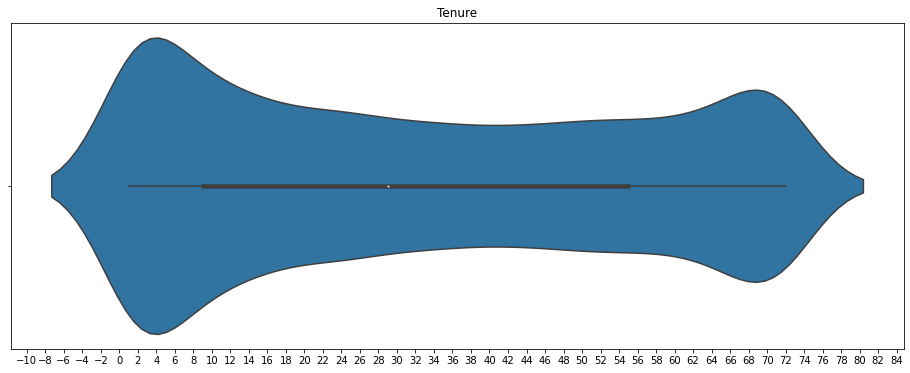

In [25]:
plt.figure(figsize=(16, 6))
plt.xticks(range(-10,100,2))
plt.title('Tenure')
sns.violinplot(x=['tenure'], data=df)

**Observation:**    
Most customers stay about 2 to 6 years. Another tenure peak is between 66 and 72 years, indicating some very loyal customers.    
The median tenure is at 29 years.    
50% of customers stay between 9 and 55 years, as indicated by the upper and lower quartiles.
This rather big range is sign of a high standard deviation and highly scattered data.

### Monthly Charges

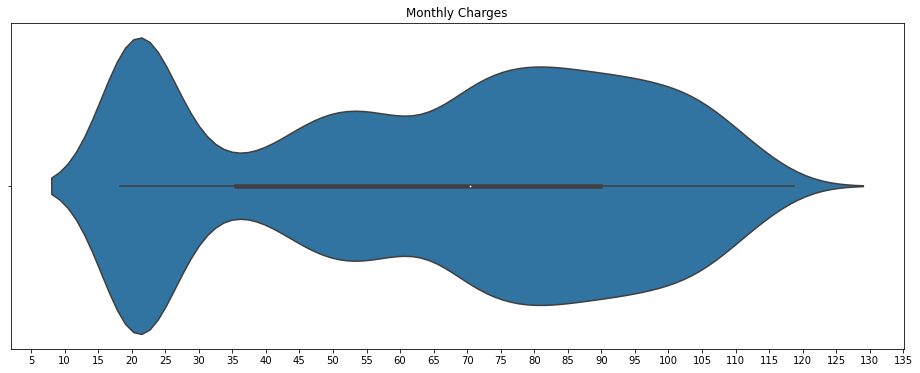

In [26]:
plt.figure(figsize=(16, 6))
plt.title('Monthly Charges')
plt.xticks(range(5,140,5))
sns.violinplot(x=['MonthlyCharges'], data=df)

**Observation:**    
Most customers pay between 18 and 25€ per month. The violin plot shows two local peaks between 48-55 and 75-85€. Overall the monthly charges feature a high standard deviation and the charges are scattered widely.

### Total Charges

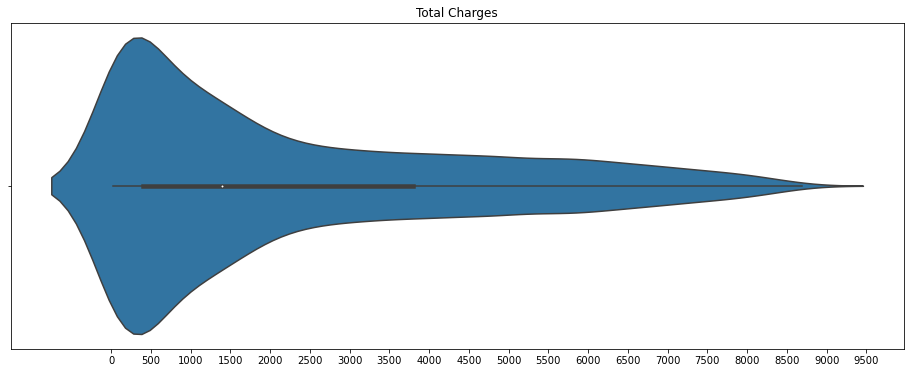

In [27]:
plt.figure(figsize=(16, 6))
plt.title('Total Charges')
plt.xticks(range(0,10000,500))
sns.violinplot(x=['TotalCharges'], data=df)

**Observation:**    
Most customers pay between 200€ and 500€ in total.
Values range up to a maximum of 8684, leading to a high standard deviation.    
The median value lies at 1400€ total charges.
50% of customers pay between 400€ and 3800€ in total, as indicated by the lower and upper quartiles.

## Understand Data: Univariate Distribution Visualization (Discrete Values)

In [33]:
# First grab the categorical subset of the data to make life easier
# To get the categorical data programmatically the data types are exploited.
df_original = pd.read_csv(path_dataset)
df_discrete = df_original[df_original.select_dtypes(['object']).columns]
df_discrete = df_discrete.drop(columns=['customerID', 'TotalCharges'])
feature_names = df_discrete.columns

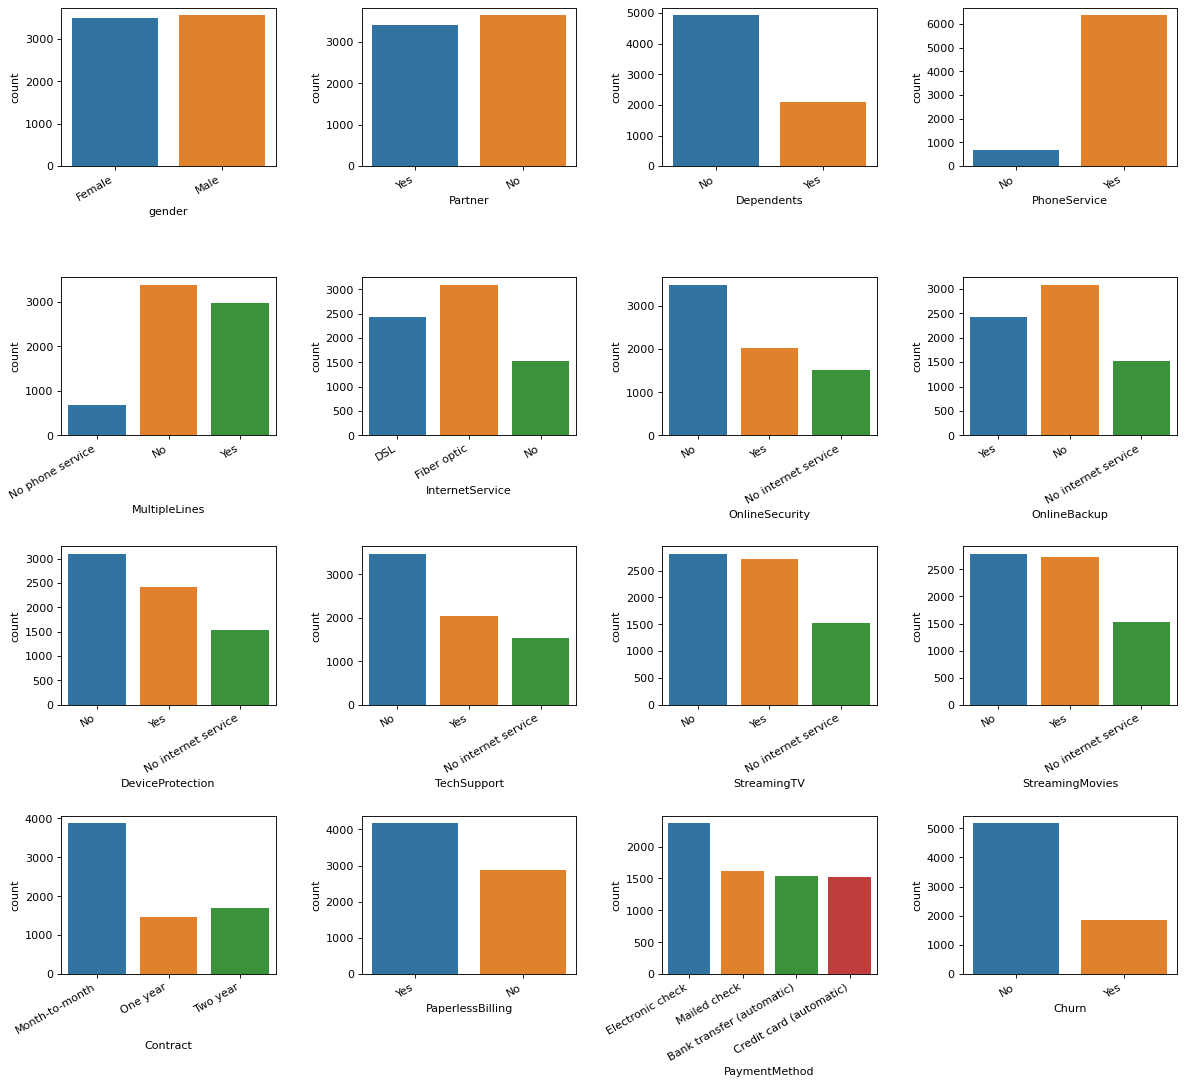

In [35]:
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.7, wspace=.4)

index = 0
for row in range(4):
    for col in range(4):
        ax = fig.add_subplot(4, 4, index+1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
        feature_name = feature_names[index]
        ax = sns.countplot(x=feature_name, data=df_discrete)
        index+=1

**Observation:**    
Some features are significantly unbalanced, e.g. Dependents, PhoneService, MultipleLines, Contract and Churn.    
Especially Churn seems to be critical, since this is the label that's supposed to be predicted.

## Understand Data: Conditional Distribution Visualization

To get a grasp of what features might be important for the Churn label we visualize conditionally on this variable.[](http://)

### Tenure (conditional on Churn label)

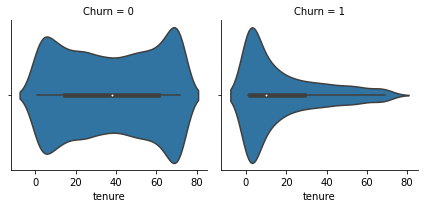

In [37]:
sns.FacetGrid(df, col='Churn').map(sns.violinplot, 'tenure', order=[0,1])

**Observation:**    
Customers with low tenure are significantly more likely to churn. At the same time customers who didn't churn are spread over a wide range of tenure.

### Monthly Charges (conditional on Churn label)

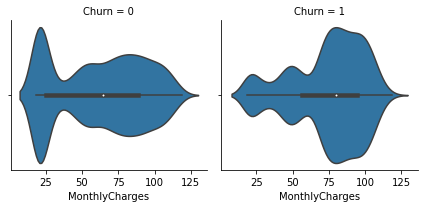

In [38]:
sns.FacetGrid(df, col='Churn').map(sns.violinplot, 'MonthlyCharges', order=[0,1])

**Observation:**    
The plot indicates that monthly charges impact the customers' decision to churn significantly.
Customers with high monthly charges are way more likely to churn than customers with a low amount of monthly charges.
On the other hand customers with low monthly charges are more likely to stay.

### Total Charges (conditional on Churn label)

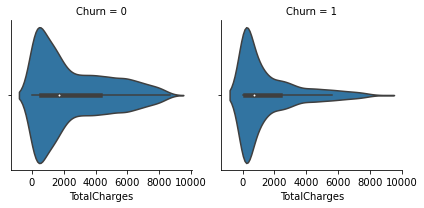

In [39]:
sns.FacetGrid(df, col='Churn').map(sns.violinplot, 'TotalCharges', order=[0,1])

**Observation:**    
The amount of total charges does not significantly impact the churn rate.
The distributions show no big discrepancy.

**General Observations:**    
By looking at the plots Tenure and and MonthlyCharges seem to be valuable features for churn prediction due to their vastly different distributions in context of the churn label.    
On the other hand TotalCharges seems to be a less valuable feature.

### Categorical Data (conditional on Churn label)

In [40]:
df_categorical = df.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges'])

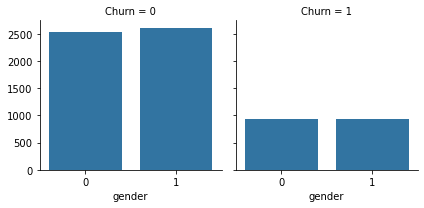

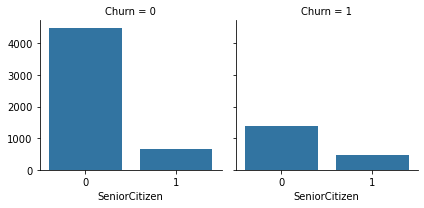

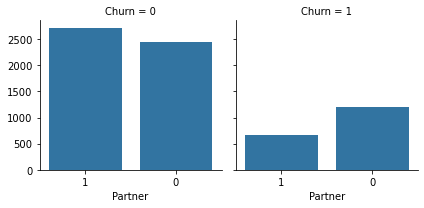

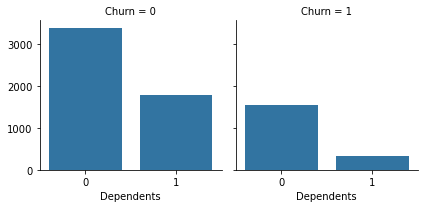

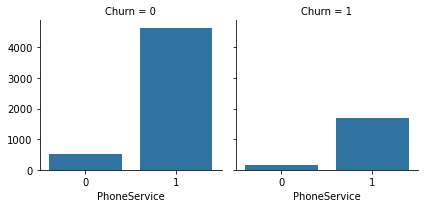

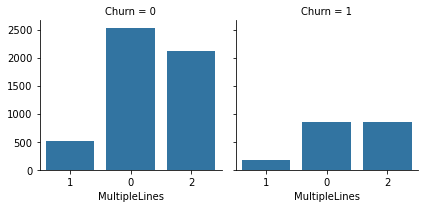

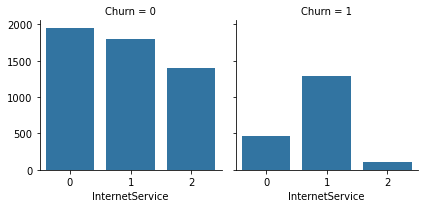

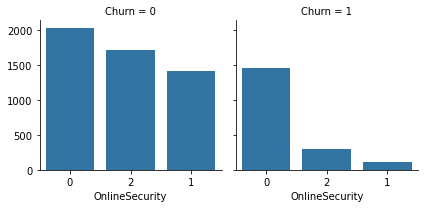

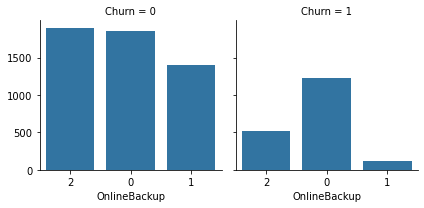

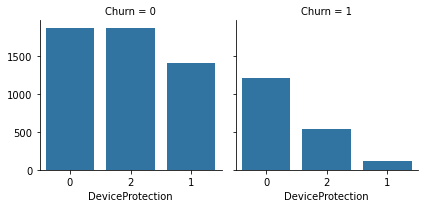

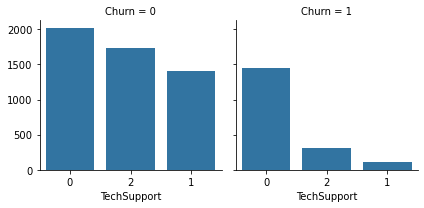

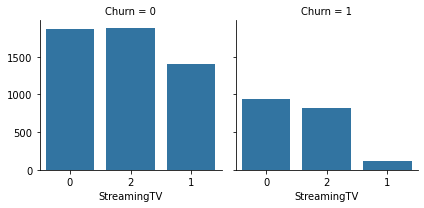

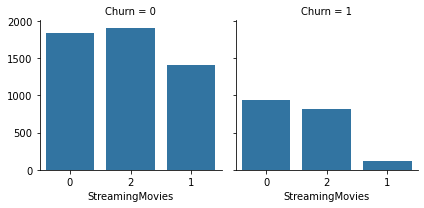

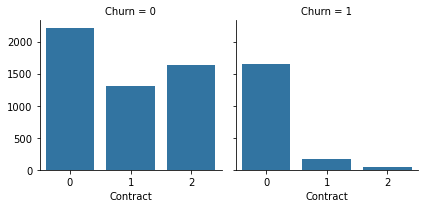

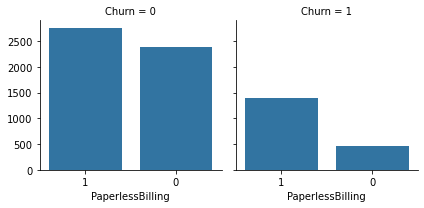

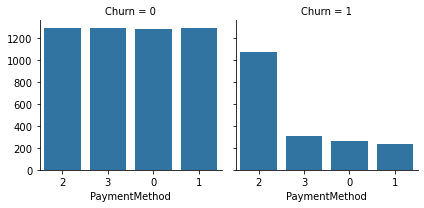

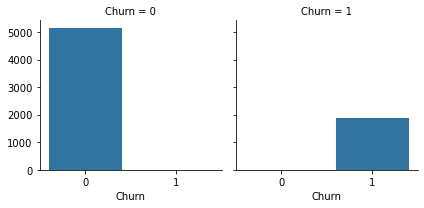

In [43]:
feature_names = df_categorical.columns

index = 0
for index in range(len(feature_names)):
    feature_name = feature_names[index]
    sns.FacetGrid(df_categorical, col='Churn').map(
        sns.countplot, feature_name, order=df_categorical[feature_name].unique())

**Observation:**    
* Gender does not seem to be a valuable feature for churn prediction. Values are evenly distributed
* Senior citizens are almost equally likely to churn or to stay. Younger customers are more likely to stay. This assumption might be biased due to a lower amount of senior citizens in the dataset.
* Customers without partner are a little more likely to churn.
* Customers with dependants are a little bit less likely to churn.
* The phone service seems to have little impact on the customer's decision.
* Multiple lines seem have little impact on the customer's decision.
* The internet service does impact the churn rate. Fiber optics customers are more likely to churn.
* Online security seems to be an important feature. Customers without online security are more likely to churn.
* The lack of online backup services increases the churn probability.
* The lack of device protection increases churn probability.
* The lack of tech support increases churn probability.
* Customers don't churn quite as often when no TV streaming is used due to no booked internet service.
* Customers don't churn quite as often when no TV streaming is used due to no booked internet service.
* Month-to-month contracts are almost equally likely to stay or to churn. Longer contracts bind the customer to the company.
* No paperless billing reduces the risk of a churn.
* Customers with electronic check billing are most likely to churn.

## Understand Data: Correlation Analysis

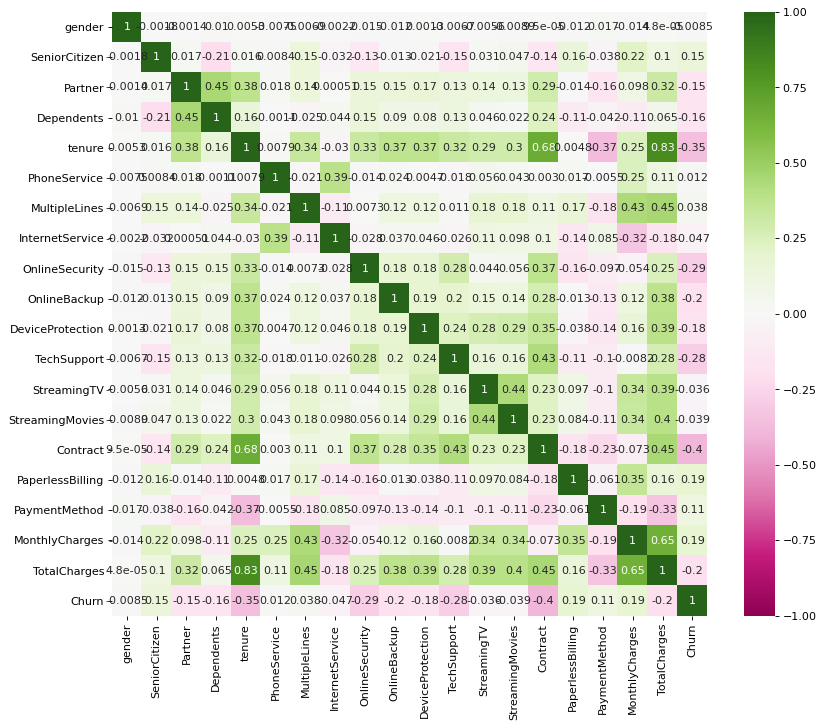

In [45]:
correlations = df.corr()
fig = plt.figure(figsize=(12,10), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(correlations, cmap='PiYG', vmin=-1, vmax=1,  annot=True)

In [46]:
correlations.Churn.sort_values()

Contract           -0.396150
tenure             -0.354049
OnlineSecurity     -0.289050
TechSupport        -0.282232
TotalCharges       -0.199484
OnlineBackup       -0.195290
DeviceProtection   -0.177883
Dependents         -0.163128
Partner            -0.149982
InternetService    -0.047097
StreamingMovies    -0.038802
StreamingTV        -0.036303
gender             -0.008545
PhoneService        0.011691
MultipleLines       0.038043
PaymentMethod       0.107852
SeniorCitizen       0.150541
PaperlessBilling    0.191454
MonthlyCharges      0.192858
Churn               1.000000
Name: Churn, dtype: float64

**Observation:**  
Some stronger correlations can be observed in the correlation heatmap, e.g. Tenure with contract and Tenure with Total Charges. The usage of additional services (e.g. streaming and security offers) tend to influence the customer's tenure, their contract type and their total charges.

In context of the Churn label shows a different picture. The strongest negative correlation is found between churn and the contract type, the strongest positive correlation is between churn and the monthly charges.

The assumption that wider value distributions with respect to the churn label leads to higher correlation values was verified by the correlation with the features Contract, MonthlyCharges and Tenure. Less distributed data on the other hand leads to lower correlation values (e.g. gender). The assumption that TotalCharges is not a potentially usable feature has been disproved. The absolute correlation value is nearly equal to MonthlyCharges. Additionally there are features with even lower correlation values.

## Univariate Feature Selection

Features will be selected based on univariate statistical tests.

In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [61]:
values = df.values

X = values[:,0:19] # Features
y = values[:,19] # Targets

# Mutual Information for Classification
mutual_info = mutual_info_classif(X, y, discrete_features='auto', 
                                    n_neighbors=3, copy=True, random_state=None)

# chi square
chi_score, chi_pval = chi2(X,y)

# F-measure
f_score, f_pval = f_classif(X,y)

data_feature_selection = { 'MutualInfo': mutual_info,
                        'ChiSquaredScore': chi_score,
                        'ChiSquaredPVal': chi_pval,
                        'FScore': f_score,
                        'FPVal': f_pval
                        }

features = df.columns[0:19]

df_feature_selection = pd.DataFrame(data_feature_selection)
df_feature_selection.insert(0, 'Feature', features)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_feature_selection

,Feature,MutualInfo,ChiSquaredScore,ChiSquaredPVal,FScore,FPVal
0,gender,0.000,0.254,0.614,0.513,0.474
1,SeniorCitizen,0.005,133.483,0.000,163.012,0.000
2,Partner,0.015,81.858,0.000,161.776,0.000
3,Dependents,0.007,131.272,0.000,192.189,0.000
4,tenure,0.071,16377.328,0.000,1007.509,0.000
5,PhoneService,0.001,0.093,0.760,0.961,0.327
6,MultipleLines,0.000,9.736,0.002,10.189,0.001
7,InternetService,0.056,9.715,0.002,15.628,0.000
8,OnlineSecurity,0.070,550.437,0.000,640.904,0.000
9,OnlineBackup,0.044,229.441,0.000,278.743,0.000


**Comparison of the test methods:**

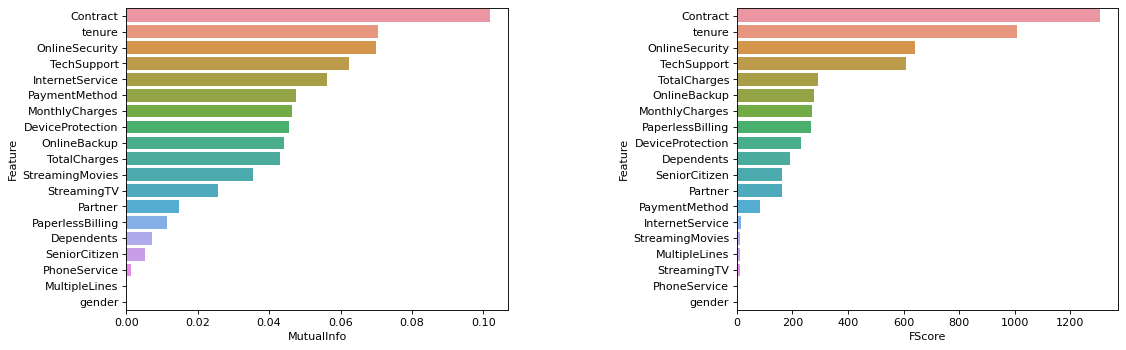

In [62]:
fig = plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.1, wspace=.6)

# Mutual Info
ax = fig.add_subplot(1, 2, 1)
ax = sns.barplot(x='MutualInfo', y="Feature", 
                 data=df_feature_selection.sort_values('MutualInfo', ascending=False))

ax = fig.add_subplot(1, 2, 2)
ax = sns.barplot(x='FScore', y="Feature", 
                 data=df_feature_selection.sort_values('FScore', ascending=False))

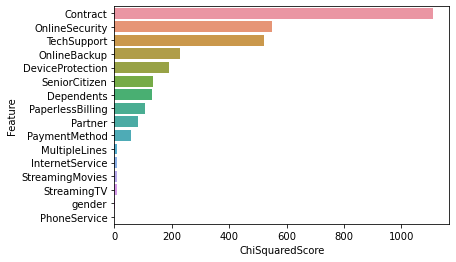

In [63]:
ax = sns.barplot(x='ChiSquaredScore', y="Feature", 
                 data=df_feature_selection.drop([4,17,18])
                 .sort_values('ChiSquaredScore', ascending=False))

**Observation:**    
Both algorithms compute different feature scores. Some feature scores show an overlap, e.g. Contract and Tenure.

The Chi Square algorithm is only usable for categorical data. Here contract is scored far ahead of other features, which corresponds to the results of the other performed tests.
This suggests that contract might be an important feature.

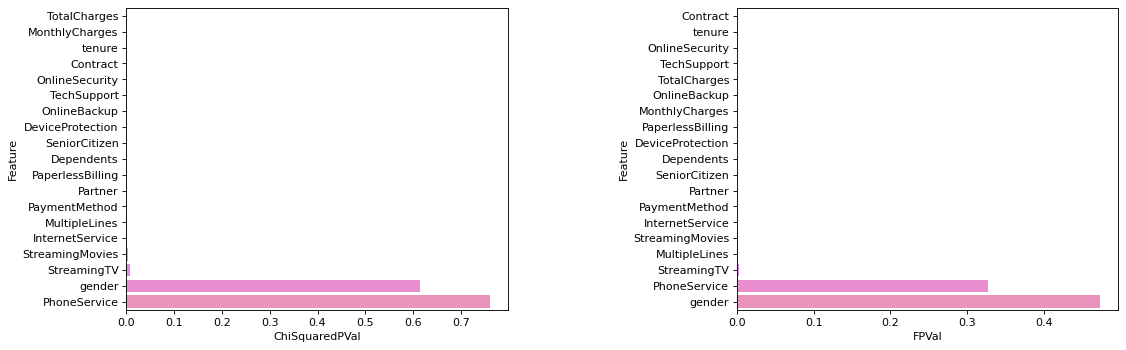

In [64]:
fig = plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.1, wspace=.6)

ax = fig.add_subplot(1, 2, 1)
ax = sns.barplot(x='ChiSquaredPVal', y="Feature", 
                 data=df_feature_selection
                 .sort_values('ChiSquaredPVal', ascending=True))

ax = fig.add_subplot(1, 2, 2)
ax = sns.barplot(x='FPVal', y="Feature", data=df_feature_selection
                 .sort_values('FPVal', ascending=True))

**Observation:**   
When taking p-values into consideration the eight best features are equal to the features shown in the bar plots above, even though their ranking differs in the case of the ChiSquared test.

The features gender and phone service show very high p-values and therefore are no valuable features.

The best features according to the mutual information are now selected with Scikit-Learns kbest algorithm.

In [65]:
selector = SelectKBest(score_func = mutual_info_classif, k = 8).fit(X,y)

feature_indices = selector.get_support(True)

print("Best 8 features (Mutual Information):")
for i in range(len(feature_indices)):
    index = feature_indices[i]
    print(df.columns[index])

Best 8 features (Mutual Information):
tenure
InternetService
OnlineSecurity
OnlineBackup
TechSupport
Contract
PaymentMethod
MonthlyCharges


## Transform Data: One Hot Encoding

Non-binary nominal data is now one-hot-encoded for consumption by ML algorithms.

In [67]:
# Extract cols with non binary data
df_object_dtypes = df_original.select_dtypes(include="object").copy()
df_object_dtypes.drop(columns = ['customerID', 'TotalCharges'], axis=1, inplace=True)
features_non_binary_categorical = []
for col in df_object_dtypes.columns:
    if(len(df_object_dtypes[col].value_counts()) > 2):
        features_non_binary_categorical.append(col)
    else:
        df_object_dtypes.drop([col], axis=1, inplace=True)
        
features_non_binary_categorical

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [70]:
from sklearn.preprocessing import OneHotEncoder
df_onehotencoded = df.copy()

for feature in features_non_binary_categorical:
    col_values = df_onehotencoded[feature].values.reshape(-1,1)
    col_values_one_hot = OneHotEncoder(sparse=False, categories='auto').fit_transform(col_values)
    col_values_one_hot = col_values_one_hot.tolist()
    
    df_onehotencoded[feature] = col_values_one_hot
    
df_onehotencoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",1,"[0.0, 0.0, 1.0, 0.0]",29.850,29.850,0
1,1,0,0,0,34,1,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",0,"[0.0, 0.0, 0.0, 1.0]",56.950,1889.500,0
2,1,0,0,0,2,1,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",1,"[0.0, 0.0, 0.0, 1.0]",53.850,108.150,1
3,1,0,0,0,45,0,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",0,"[1.0, 0.0, 0.0, 0.0]",42.300,1840.750,0
4,0,0,0,0,2,1,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",1,"[0.0, 0.0, 1.0, 0.0]",70.700,151.650,1


## Transform Data: Scaling

In [72]:
# Standardized features
df_standardized = ((df-df.mean())/
                   df.std())
df_standardized.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,-1.009,-0.440,1.036,-0.652,-1.280,-3.056,0.063,-1.184,-0.918,1.243,-1.027,-0.924,-1.113,-1.121,-0.827,0.829,0.400,-1.162,-0.994,-0.602
1,0.991,-0.440,-0.966,-0.652,0.064,0.327,-0.991,-1.184,1.408,-1.029,1.245,-0.924,-1.113,-1.121,0.374,-1.206,1.337,-0.261,-0.174,-0.602
2,0.991,-0.440,-0.966,-0.652,-1.239,0.327,-0.991,-1.184,1.408,1.243,-1.027,-0.924,-1.113,-1.121,-0.827,0.829,1.337,-0.364,-0.960,1.662
3,0.991,-0.440,-0.966,-0.652,0.512,-3.056,0.063,-1.184,1.408,-1.029,1.245,1.397,-1.113,-1.121,0.374,-1.206,-1.474,-0.748,-0.195,-0.602
4,-1.009,-0.440,-0.966,-0.652,-1.239,0.327,-0.991,0.173,-0.918,-1.029,-1.027,-0.924,-1.113,-1.121,-0.827,0.829,0.400,0.196,-0.940,1.662


## Train / Test Split

In [73]:
from sklearn.model_selection import train_test_split

In [77]:
features = df.columns[0:19]
target = df.columns[19]

x_train, x_test, y_train, y_test = train_test_split(df[features],
                                                   df[target],
                                                   test_size = 0.3,
                                                   random_state = 10)

print(f'Shape of training set X: {x_train.shape}')
print(f'Shape of training set y: {y_train.shape}')
print('---')
print(f'Shape of test set X: {x_test.shape}')
print(f'Shape of test set y: {y_test.shape}')

Shape of training set X: (4922, 19)
Shape of training set y: (4922,)
---
Shape of test set X: (2110, 19)
Shape of test set y: (2110,)


## Data Pipeline

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

In [85]:
# Preparations needed for the pipelines
# We want to scale the numerical data and we want to onehot encode the categorical data.
# For this we make use of a ColumnTransformer
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Generate a mask identifying the features that are supposed to be one hot encoded
one_hot_mask = (df_original.drop(columns=['Churn', 'customerID']).dtypes == object).values

#Define the pipeline steps
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(sparse=False, categories='auto'), categorical_features),
    remainder='passthrough'
)

pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ("KBest", SelectKBest(mutual_info_classif, k=8)),
    ('Classifier', LogisticRegression(solver ='liblinear'))
])

## Fit & Evaluate

In [86]:
# Print a confusion matrix and values for accuracy, precision, recall and f1-measure
def calculate_results(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
        
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')
    
    return accuracy, precision, recall, f1

In [90]:
# Execute pipeline
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True) 

Predicted,0,1,All
True,,,
0,1361,190,1551
1,242,317,559
All,1603,507,2110


In [92]:
_ = calculate_results(y_test, y_pred)

Accuracy: 0.795260663507109
Precision: 0.6252465483234714
Recall: 0.5670840787119857
F1-Score: 0.5947467166979363


In [93]:
# Baseline - always predict 0
pipeline = Pipeline([
    ('Classifier', DummyClassifier(strategy='constant', constant=0))
]) 

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

#confusion_matrix(y_test, y_pred) - #Sklearn function to create a confusion matrix.
# pd confusion matrix -> better visualization
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True) 

Predicted,0,All
True,,
0,1551,1551
1,559,559
All,2110,2110


In [94]:
_ = calculate_results(y_test, y_pred)

Accuracy: 0.7350710900473933
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**    
To evalute the model multiple measures are considered:
The accuracy alone is misleading, as it requires a symmetric dataset with an equal data distributions. As we can see above always predicting label 0 results in an accuracy of 73%.    
Depending on the classification problem the F1 score is a better metric. It's the weighted average of Precision and Recall and therefore works best if the cost of false positives and false negatives are nearly equal.